In [97]:
import matplotlib
from common.classification import k_neighbours_leave_one_out, display_confusion_matrix
from common.clustering import k_means_multiple_dim_clustering, plot_2d_data_with_clusters, \
    plot_means_in_clusters_for_given_column, plot_1d_data_with_clusters
from common.outliers import find_outliers_in_multiple_columns, plot_2d_data_with_outliers, drop_outliers_from_dataset
from common.standardization import standardize, de_standardize
import pandas as pd
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Dataset loading and preparation
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [98]:
second_sales = "EU_Sales"

# load dataset from file
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)

# choose 7th gen consoles
print(data["Platform"].unique())
sixth_gen = ["PS2", "XB", "DC", "GC"]
seventh_gen = ["PS3", "Wii", "X360"]
data = data.loc[data["Platform"].isin(seventh_gen)]

# remove unused columns
columns_used_for_clustering = ["Critic_Score", "NA_Sales", second_sales]
data = data.filter(items=columns_used_for_clustering)

# compute stats for each column
stats_to_compute = ["max", "min", "std", "mean", "median"]
columns_stats = data.agg({item: stats_to_compute for item in columns_used_for_clustering})

['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG']


### Helper plots

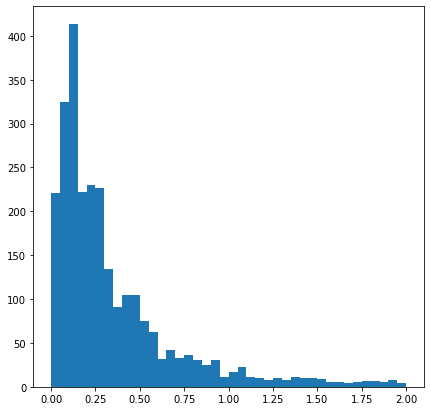

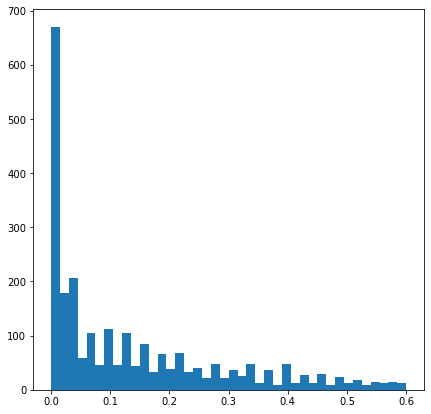

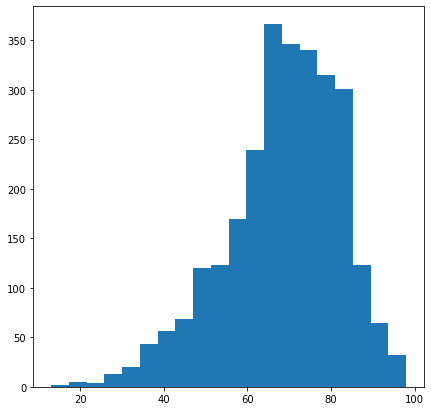

In [99]:
plt.figure()
plt.hist(data["NA_Sales"], 40, range=(0, 2.0))
plt.show()

plt.figure()
plt.hist(data[second_sales], 40, range=(0, 0.6))
plt.show()

plt.figure()
plt.hist(data["Critic_Score"], 20)
plt.show()

### Data standardization

In [100]:
standardize(data, columns_used_for_clustering, columns_stats)

### Outliers detection

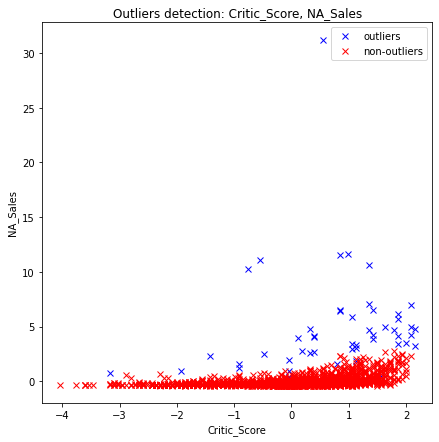

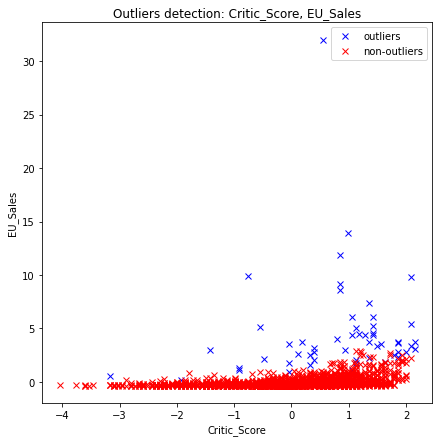

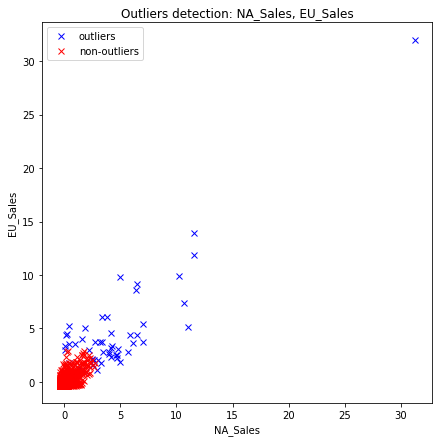

In [101]:
k_neighbours = 5
r_percentage = 0.02
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

plot_2d_data_with_outliers(outliers, non_outliers, ("Critic_Score", "NA_Sales"))
plot_2d_data_with_outliers(outliers, non_outliers, ("Critic_Score", second_sales))
plot_2d_data_with_outliers(outliers, non_outliers, ("NA_Sales", second_sales))

### Clustering

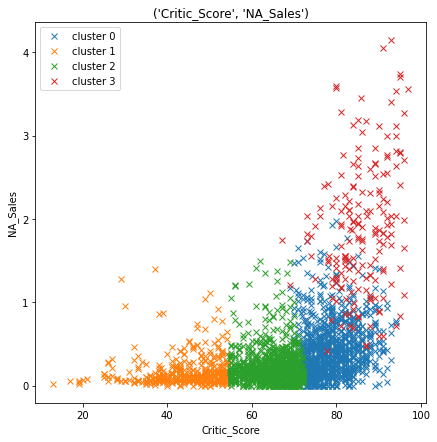

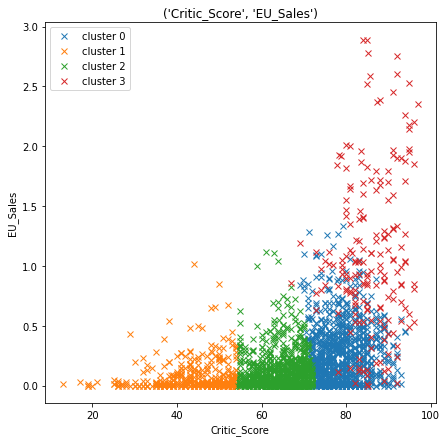

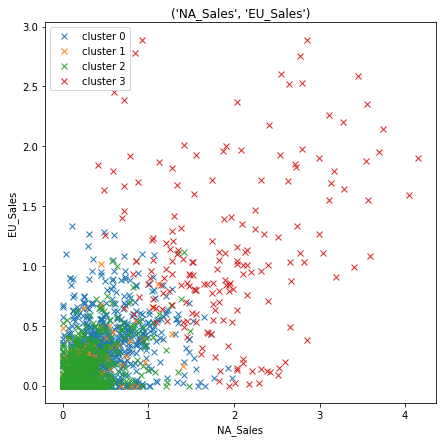

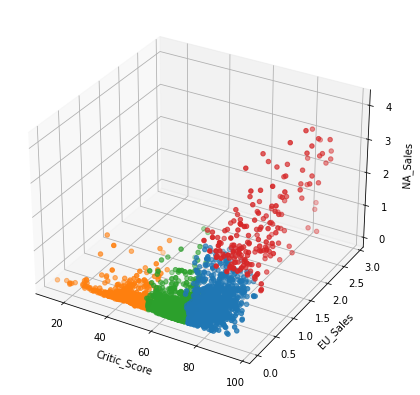

In [102]:
data_without_outliers = drop_outliers_from_dataset(data, outliers)
clustered_data = k_means_multiple_dim_clustering(data_without_outliers, columns_used_for_clustering, 4)

de_standardize(clustered_data, columns_used_for_clustering, columns_stats)
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "NA_Sales"))
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", second_sales))
plot_2d_data_with_clusters(clustered_data, ("NA_Sales", second_sales))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
number_of_clusters = clustered_data["cluster"].max() + 1
for cluster_index in range(0, number_of_clusters):
    cluster_data = clustered_data[clustered_data["cluster"] == cluster_index]
    ax.scatter(cluster_data["Critic_Score"], cluster_data[second_sales], cluster_data["NA_Sales"])

ax.set_xlabel('Critic_Score')
ax.set_ylabel(second_sales)
ax.set_zlabel('NA_Sales')
plt.show()


### Compute and display stats for each cluster

         Critic_Score  NA_Sales  EU_Sales
cluster                                  
0           78.766112  0.429638  0.258276
1           44.497087  0.170121  0.076699
2           64.448145  0.222152  0.102857
3           85.848913  1.894022  1.116793


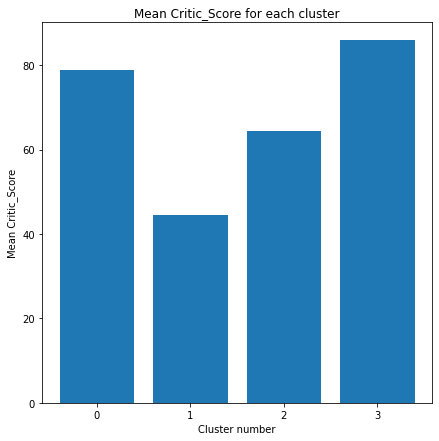

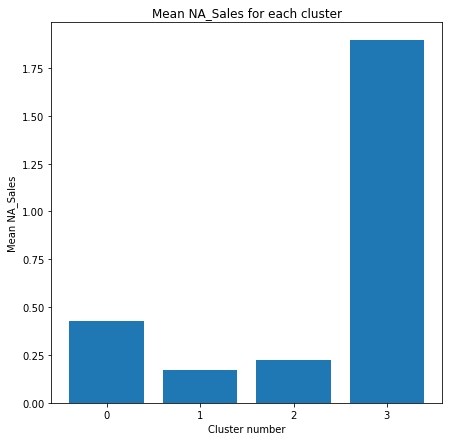

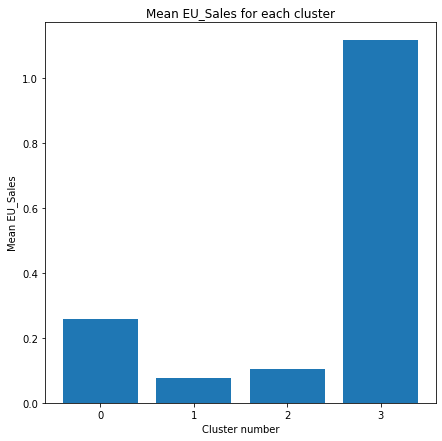

In [103]:
data_means_grouped_by_clusters = clustered_data.groupby("cluster").mean()
print(data_means_grouped_by_clusters)

plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "Critic_Score")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "NA_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, second_sales)


### Classification (to clusters)

0.9862708719851577


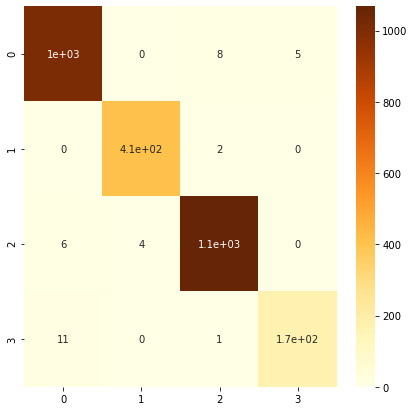

In [104]:
standardize(clustered_data, columns_used_for_clustering, columns_stats)
classification_quality, confusion_matrix = k_neighbours_leave_one_out(clustered_data, "cluster", 3)
print(classification_quality)
display_confusion_matrix(confusion_matrix)
de_standardize(clustered_data, columns_used_for_clustering, columns_stats)

### Classification - NA_Sales prediction using other sales and Critic_Score

Cluster 0 size: 1232
Cluster 1 size: 1051
Cluster 2 size: 412
0.6014842300556587


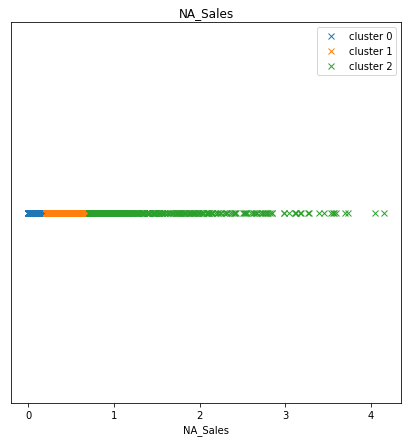

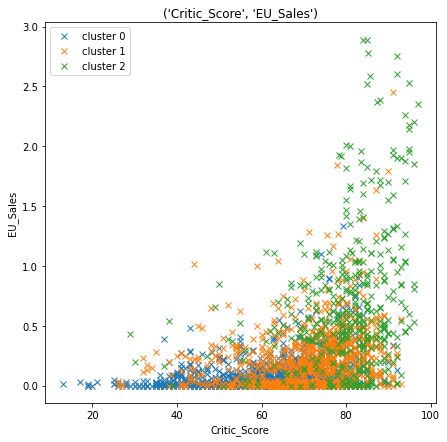

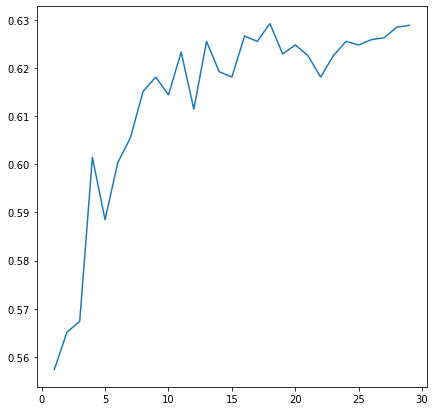

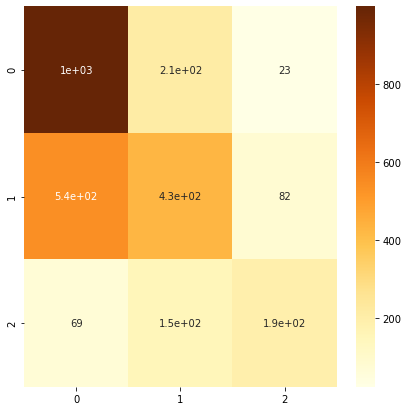

In [105]:
data = clustered_data.drop(["cluster"], axis=1)
data["cluster"] = 0
data.loc[data["NA_Sales"] > 0.2, "cluster"] = 1
data.loc[data["NA_Sales"] > 0.7, "cluster"] = 2

for i in range(0, 3):
    print("Cluster {} size: {}".format(i, data[data["cluster"] == i].shape[0]))

plot_1d_data_with_clusters(data, "NA_Sales")
plot_2d_data_with_clusters(data, ("Critic_Score", second_sales))

data = data.drop(["NA_Sales"], axis=1)
standardize(data, [second_sales, "Critic_Score"], columns_stats)

should_check_qualities = False
if should_check_qualities:
    qualities = []
    for number_of_neighbours in range(1, 30):
        classification_quality, confusion_matrix = k_neighbours_leave_one_out(data, "cluster", number_of_neighbours)
        qualities.append(classification_quality)

    plt.figure()
    plt.plot(range(1, 30), qualities)
    plt.show()

classification_quality, confusion_matrix = k_neighbours_leave_one_out(data, "cluster", 4)
print(classification_quality)
display_confusion_matrix(confusion_matrix)